In [27]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time
import random
from scipy.linalg import block_diag
from sklearn.metrics import precision_recall_curve, auc
import scipy.stats
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import random
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from collections import defaultdict

import sys
# sys.path.append('/Users/yijwang-admin/Documents/Research/GFL/Code/PQN_Python_main')
from minConf.minConf_PQN import minConF_PQN
import random
import itertools
import os
import matlab.engine
from sklearn.linear_model import Lasso

In [2]:
import numpy as np
from scipy.sparse import spdiags
from scipy.linalg import inv
from gurobipy import Model, GRB, QuadExpr

def Lasso(u, X, y, rho):
    n, d = X.shape
    D_u = spdiags(u.flatten(), 0, d, d)
    M = inv((1/rho) * X @ D_u @ X.T + np.eye(n))
    f = y.T @ M @ y
    g = -(1/rho) * ((X.T @ M @ y)**2)

    return f, g

def GroupLasso(u, X, y, rho):
    n, d = X.shape
    D_u = spdiags(u.flatten(), 0, d, d)
    M = inv((1/rho) * X @ D_u @ X.T + np.eye(n))
    f = y.T @ M @ y
    g = -(1/(2*rho)) * ((X.T @ M @ y)**2)

    return f, g

def GeneralizedFusedLasso(u, X, y, rho, L, mu):
    n, d = X.shape
    D_u = spdiags(u.flatten(), 0, d, d)
    M = inv((1/rho) * X @ D_u @ X.T + np.eye(n))
    f = (1/2) * y.T @ M @ y + mu * u.T @ L @ u
    g = -(1/(2*rho)) * ((X.T @ M @ y)**2) + 2 * mu * L @ u

    return f.flatten(), g.flatten()


def ProjLassoGurobi(u, k, d):
    A = np.ones((1, d))
    b = np.array([k])
    Q = np.eye(d)
    f = -2 * u.flatten()

    model = Model("GeneralizedFusedLasso")
    x = model.addMVar(d, lb=0.0, ub=1.0)

    model.setObjective(x@Q@x + x@f)
    model.addConstr(A @ x == b)

    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    model.optimize()
    # print("Lasso x.x: ", x.x)

    return x.x

def ProjGroupLassoGurobi(u, k, groups, h, d):
    """
    Solves the Group Lasso projection problem using Gurobi.

    Parameters:
    - u: Input vector of size (d, 1)
    - k: Sparsity level (L1 constraint)
    - groups: List of groups, where each group is a list of indices
    - h: Sum constraint for group norms

    Returns:
    - up: Projected vector (u')
    - zp: Auxiliary variables for group norms
    """
    # d = u.shape  # Number of variables
    g = len(groups)  # Number of groups

    # Quadratic objective matrices and linear term
    H1 = np.eye(d)  # Identity for quadratic term on `u`
    f1 = -2 * u.flatten()  # Linear term for `u`
    H2 = np.zeros((g, g))  # No quadratic term for auxiliary variables
    f2 = np.zeros(g)  # No linear term for auxiliary variables

    # Combine H1, H2 and f1, f2 into block matrices
    H = np.block([[H1, np.zeros((d, g))], [np.zeros((g, d)), H2]])
    f = np.concatenate([f1, f2])

    # Constraint matrices for `u` (A1) and `z` (A2)
    A1 = np.vstack([np.ones((1, d)), -np.ones((1, d))])  # L1 constraint on `u`
    A2 = np.zeros((2, g))  # Initialize A2
    group_constraints_count = 0

    # Build group constraints
    for i, group in enumerate(groups):
        for idx in group:
            A1_row = np.zeros((1, d))
            A1_row[0, idx] = 1
            A1 = np.vstack([A1, A1_row])  # Adding constraints for group indices

            A2_row = np.zeros((1, g))
            A2_row[0, i] = -1
            A2 = np.vstack([A2, A2_row])  # Adding constraints for group norms
            group_constraints_count += 1

    # Add overall group norm constraint
    A1 = np.vstack([A1, np.zeros((1, d))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])  # Combine A1 and A2

    # RHS vector for constraints
    b = np.zeros(group_constraints_count + 3)
    b[0] = k  # Sparsity constraint (sum of u <= k)
    b[1] = -k + 1  # Lower bound for sparsity
    b[-1] = h  # Sum constraint for group norms

    # Lower and upper bounds for variables
    lb = np.zeros(d + g)
    ub = np.ones(d + g)

    # Setup Gurobi model
    model = Model("ProjGroupLasso")
    x = model.addMVar(d + g, lb=lb, ub=ub)  # Variables for `u` and `z`

    # Set quadratic objective
    model.setObjective(x @ H @ x + x @ f)

    # Add constraints
    model.addConstr(A @ x <= b)

    # Configure Gurobi parameters
    model.setParam('OutputFlag', 0)  # Suppress output
    model.setParam('IterationLimit', 500)
    # Solve the model
    model.optimize()

    # Extract the results
    up = x.x[:d]  # Projected vector `u'`
    zp = x.x[d:]  # Auxiliary variables `z'`

    # print("GroupLasso x.x: ", up[:, np.newaxis])

    return up


def ProjGeneralizedFusedLassoGurobi(u, k, d):
    A = np.ones((1, d))
    b = np.array([k])
    c = np.array([k-1])
    
    # A = np.vstack([A, -np.ones((1, d))])
    # b = np.vstack([b, -k + 1])
    Q = np.eye(d)
    f = -2 * u.flatten()

    model = Model("GeneralizedFusedLasso")
    x = model.addMVar(d, lb=0.0, ub=1.0)

    model.setObjective(x@Q@x + x@f)
    model.addConstr(A @ x <= b)
    # model.addConstr(A @ x >= c)

    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    model.optimize()
    # print("GeneralizedFusedLasso x.x: ", x.x)

    return x.x

In [46]:
class RandomEnsemble:
    def __init__(self, n, d, k, h_total, h_selected, h_rest, gamma, 
                 p=0.95, q=0.01, 
                 options=None, num_replications=20,
                 datafile=f'./code_fgfl_aaai14/data_gfl/',
                 resultfile='./code_fgfl_aaai14/result_gfl/'):
        assert h_total == h_selected + h_rest, "h_total should be equal to h_selected + h_rest"
        self.n = n
        self.d = d
        self.k = k
        self.h_total = h_total
        self.h_selected = h_selected
        self.h_rest = h_rest
        self.gamma = gamma
        self.p = p
        self.q = q
        self.options = options if options else {'maxIter': 500, 'verbose': 0, 'SPGiters': 100}
        self.num_replications = num_replications
        self.datafile = os.path.join(os.path.abspath(datafile), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self.resultfile = os.path.join(os.path.abspath(resultfile), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}') # matlab does not like relative path
        self.best_rho1 = 0.5
        self.best_rho2 = 0.5
        self.best_mu = 1.0
        # self.best_rho = np.sqrt(self.n) * 6.8
        self.best_rho = np.sqrt(self.n)
        self.datafile_pqn = os.path.join(os.path.abspath('./PQN/data/'), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self.resultfile_pqn = os.path.join(os.path.abspath('./PQN/result/'), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self._init(self.datafile, self.resultfile)
        self._init(self.datafile_pqn, self.resultfile_pqn)

    
    def _init(self, datafile, resultfile):
        if not os.path.exists(datafile):
            os.makedirs(datafile)
        if not os.path.exists(resultfile):
            os.makedirs(resultfile)

    def _random_partition(self):
        # partition the first k nodes into h_selected groups and the rest into h_rest groups
        assert self.h_selected <= self.k, "h_selected should be less than k"
        assert self.h_rest <= self.d - self.k, "h_rest should be less d-k"
        if self.k % self.h_selected != 0 or (self.d - self.k) % self.h_rest != 0:
            break_points = np.sort(random.sample(range(1, self.k), self.h_selected-1))
            break_points_rest = np.sort(random.sample(range(self.k+1, self.d), self.h_rest-1))
        else: # evenly divide the nodes
            break_points = np.arange(self.k // self.h_selected, self.k, self.k // self.h_selected)
            break_points_rest = np.arange(self.k + (self.d - self.k) // self.h_rest, self.d, (self.d - self.k) // self.h_rest)
            
        return break_points, break_points_rest
    
    def _generate_clusters(self):
        break_points, break_points_rest = self._random_partition()
        clusters = []
        clusters.append(np.arange(break_points[0])) # first selected cluster
        for i in range(1, self.h_selected-1):
            clusters.append(np.arange(break_points[i-1], break_points[i]))
        clusters.append(np.arange(break_points[-1], self.k)) # last selected cluster

        clusters.append(np.arange(self.k, break_points_rest[0])) # first rest cluster
        for i in range(1, self.h_rest-1):
            clusters.append(np.arange(break_points_rest[i-1], break_points_rest[i]))
        clusters.append(np.arange(break_points_rest[-1], self.d))

        return clusters

    def _generate_graph(self):
        # here we generate the adjacency matrix and laplacian of the graph
        clusters = self._generate_clusters()

        A = sp.lil_matrix((self.d, self.d))
        
        # generate thr inner cluster connections
        for cluster in clusters:
            cluster_size = len(cluster)
            block = (np.random.rand(cluster_size, cluster_size) < self.p).astype(int)
            np.fill_diagonal(block, 0) # no self-loop
            block = np.triu(block) + np.triu(block, 1).T # make it symmetric
            for i, node_i in enumerate(cluster):
                for j, node_j in enumerate(cluster):
                    A[node_i, node_j] = block[i, j]

        # generate the connections between clusters
        for i in range(self.h_total):
            for j in range(i+1, self.h_total):
                cluster_i = clusters[i]
                cluster_j = clusters[j]
                block = (np.random.rand(len(cluster_i), len(cluster_j)) < self.q).astype(int)
                for m, node_i in enumerate(cluster_i):
                    for n, node_j in enumerate(cluster_j):
                        A[node_i, node_j] = block[m, n]
                        A[node_j, node_i] = block[m, n]

        # TODO: check if the graph is connected and make it connected if not 
        # (optional, maybe not necessary)
        D = sp.diags(np.ravel(A.sum(axis=1)))
        L = D - A
        return L, clusters, A
    
    def _visualize_graph(self, A):
        # if we want to visualize the graph, we need to change it to array rather than sparse matrix
        A_arr = A.toarray()
        plt.figure(figsize=(8, 8))
        plt.title('Adjacency matrix')
        plt.spy(A_arr)
        plt.axis('off')
        plt.show()

    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        for i in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = cluster_sign * (1 / np.sqrt(self.k)) # TODO: make more choice other than 1/sqrt(k)
            for node in clusters[i]:
                w[node] = cluster_weight
        # w = w[:, np.newaxis]
        return w

    def _generate_X(self):
        # X = np.random.normal(0, 1, (self.n, self.d))
        mean = np.zeros(self.d)
        cov = np.eye(self.d)
        X = np.random.multivariate_normal(mean, cov, self.n)
        return X
    
    def _generate_y(self, X, w):
        signal = X @ w
        noise = np.random.normal(0, self.gamma, signal.shape)
        y = signal + noise
        SNR = self._compute_snr(signal, noise)
        if 0: # TODO: add a debug/verbose flag
            print(f'SNR: {SNR}')

        return y

    def _generate_data(self):
        L, clusters, A = self._generate_graph()
        if 0: # TODO: add a debug/verbose flag 
            self._visualize_graph(A)
        w = self._generate_w(clusters)
        X = self._generate_X()
        y = self._generate_y(X, w)
        return L, w, X, y, clusters, A


    def _compute_snr(self, signal, noise):  
        # in our case, the snr is 10*log10(1/gamma^2)
        signal = np.asarray(signal)
        noise = np.asarray(noise)

        signal_power = np.mean(signal ** 2)
        noise_power = np.mean(noise ** 2)
        
        snr = signal_power / noise_power
        snr_db = 10 * np.log10(snr)
        
        return snr_db
    
    def _define_obj(self, model, X, y, rho=1, L=None, mu=None):
        """
        Support models: 'Lasso', GroupLasso', 'GeneralizedFusedLasso'
        I plan to support Proximal method by calling matlab session
        this part and the one below is to support PQN, the Proxiaml method is on its own, it does not need this
        """
        if model == "Lasso":
            return lambda u: Lasso(u, X, y, rho)
        elif model == "GroupLasso":
            return lambda u: GroupLasso(u, X, y, rho)
        elif model == "GeneralizedFusedLasso":
            return lambda u: GeneralizedFusedLasso(u, X, y, rho, L, mu)
        else:
            raise ValueError("Model not supported")
        
    def _define_projection(self, model, groups=None):
        """
        Support models: 'Lasso', GroupLasso', 'GeneralizedFusedLasso'
        """
        if model == "Lasso":
            return lambda u: ProjLassoGurobi(u, self.k, self.d)
        elif model == "GroupLasso":
            return lambda u: ProjGroupLassoGurobi(u, self.k, groups, self.h_selected, self.d)
        elif model == "GeneralizedFusedLasso":
            return lambda u: ProjGeneralizedFusedLassoGurobi(u, self.k, self.d)
        else:
            raise ValueError("Model not supported")
        
    def _max_degree(self, L):
        # find the maximum degree of the graph according to the laplacian matrix
        return np.max(np.diag(L.toarray()))
    
    def solver(self, model, X, y, clusters=None, L=None, A=None, i=None, rho=1, mu=1):
        if model == "Proximal":
            return self._solver_proximal(X, y, A, i)
        elif model == "Lasso":
            rho = np.sqrt(self.n) # TODO: check if this is the correct value
            # funObj = self._define_obj(model, X, y, rho)
            # funProj = self._define_projection(model)
            return self._solver_gfl(X, y, L, i, rho, mu=0.0)
        elif model == "GroupLasso":
            rho = np.sqrt(self.n) # TODO: check if this is the correct value
            funObj = self._define_obj(model, X, y, rho)
            funProj = self._define_projection(model, clusters)
        elif model == "GeneralizedFusedLasso":
            # max_degree = self._max_degree(L)
            # rho = 3.4 * self.k * 2 * mu * 2 * max_degree  # TODO: check if this is the correct value
            # rho = np.sqrt(self.n) # TODO: check if this is the correct value
            if i == 0:
                # rho_values = [1, 10, np.sqrt(self.n), 50, 70, 100] # sqrt(300)=17.32
                # rho_values = [10, np.sqrt(self.n), 50, 100]
                rho_values = [0.1, 0.5, 1.0, 5.0]
                mu_values = [0.01, 0.1, 1.0]
                self.best_rho, self.best_mu = self._cross_validation_gfl(X, y, L, rho_values, mu_values)
            else:
                rho = self.best_rho
                mu = self.best_mu
            funObj = self._define_obj(model, X, y, rho, L, mu)
            funProj = self._define_projection(model)
        elif model == "GFL_Matlab":
            # rho = np.sqrt(self.n) # TODO: check if this is the correct value
            # mu = 1.0
            return self._solver_gfl(X, y, L, i)
        elif model == "Lasso_Sklearn":
            return self._solver_lasso_sklearn(X, y)
        else:
            raise ValueError("Model not supported")
        
        uSimplex = np.ones((self.d, 1)) / self.d
        uout, obj, _ = minConF_PQN(funObj, uSimplex, funProj, self.options)
        # uout = funProj(uout) # TODO: check if this is necessary

        self._save_result(uout, f'./res/result_{model}_{i}.mat')

        return uout
    
    def _solver_lasso_sklearn(self, X, y):
        """
        Use sklearn's Lasso implementation to solve the Lasso problem.
        """
        alpha = 0.1
        lasso_model = Lasso(alpha=alpha, max_iter=10000)  # Lasso model with high max_iter
        lasso_model.fit(X, y)  # Fit the model
        u = lasso_model.coef_  # Get the coefficients
        # print(f"Lasso coefficients: {u}")
        return u
    
    def _solver_gfl(self, X, y, L, i, rho=None, mu=None):
        datafile_pqn = os.path.join(self.datafile_pqn, f'data_{i}.mat')
        resultfile_pqn = os.path.join(self.resultfile_pqn, f'result_{i}.mat')
        if rho is None or mu is None: # we don't need to store the data when we do Lasso
            self._save_mat_pqn(X, y, L, datafile_pqn)
        if rho is None or mu is None:
            if i == 0:
                rho_values = [np.sqrt(self.n), 6.8 * np.sqrt(self.n)]
                mu_values = [0.01, 0.1, 1.0]
                self.best_rho, self.best_mu = self._cross_validation_gfl(X, y, L, rho_values, mu_values)
                print(f"Best rho: {self.best_rho}, Best mu: {self.best_mu}")
            rho = self.best_rho
            mu = self.best_mu

        self._call_gfl(datafile_pqn, resultfile_pqn, rho, mu)
        u, _ = self._read_result(resultfile_pqn)
        return u.flatten()
    
    def _save_mat_pqn(self, X, y, L, filename=None):
        # save the data to .mat file so that the matlab code of proxiaml can use it
        # print("X.shape", X.shape)   
        # print("y.shape", y.shape)
        # print("A.shape", A.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        data = {
            "X": X,
            "y": y,
            "L": L.toarray() if sp.issparse(L) else L,  # we store the adjacency matrix as dense matrix
        }
        sio.savemat(filename, data)

    
    def _call_gfl(self, datafile, resultfile, rho, mu):
        eng = matlab.engine.start_matlab()
        try:
            eng.cd(os.path.abspath('./PQN/'))
            eng.addpath(os.path.abspath('./PQN/'))
            eng.addpath(eng.genpath(os.path.abspath('./PQN/')))
            eng.addpath(eng.genpath(os.path.abspath('./PQN/minConF/')))
            eng.gfl_pqn(datafile, resultfile, rho, mu, nargout=0)
        finally:
            eng.quit()
    
    def _save_result(self, u, filename):
        sio.savemat(filename, {'beta': u})
    
    def _gfl_helper(self, X, y, L, rho, mu):
        funObj = self._define_obj("GeneralizedFusedLasso", X, y, rho, L, mu)
        funProj = self._define_projection("GeneralizedFusedLasso")
        uSimplex = np.ones((self.d, 1)) / self.d
        uout, obj, _ = minConF_PQN(funObj, uSimplex, funProj, self.options)
        uout = funProj(uout) # TODO: check if this is necessary

        return uout

    
    def _call_proximal(self, datafile, resultfile, rho1, rho2):
        eng = matlab.engine.start_matlab()
        try:
            eng.cd(os.path.abspath('./code_fgfl_aaai14/'))
            eng.addpath(os.path.abspath('./code_fgfl_aaai14/GFL/'))
            eng.addpath(eng.genpath(os.path.abspath('./code_fgfl_aaai14/')))
            eng.gfl_proximal(datafile, resultfile, rho1, rho2, nargout=0)
        finally:
            eng.quit()

    def _cross_validation(self, X, y, A, rho1_values, rho2_values, k_folds=5):
        results = []
        n = self.n
        indices = np.arange(n)
        np.random.shuffle(indices)
        folds = np.array_split(indices, k_folds)
        datafile = os.path.join(self.datafile, 'data.mat') 
        resultfile = os.path.join(self.resultfile, 'result.mat')

        for rho1, rho2 in itertools.product(rho1_values, rho2_values):
            mse_list = []
            for fold in folds:
                train_indices = np.setdiff1d(indices, fold)
                test_indices = fold
                X_train, y_train = X[train_indices], y[train_indices]
                X_test, y_test = X[test_indices], y[test_indices]

                self._save_mat(X_train, y_train, A, datafile)
                self._call_proximal(datafile, resultfile, rho1, rho2)
                u, funcVal = self._read_result(resultfile)      
                mse = np.mean((X_test @ u - y_test) ** 2)
                mse_list.append(mse)

            avg = np.mean(mse_list)
            results.append((rho1, rho2, avg))

        best_rho1, best_rho2, _ = min(results, key=lambda x: x[2])
        return best_rho1, best_rho2
    
    def _cross_validation_gfl(self, X, y, L, rho_values, mu_values, k_folds=5):
        results = []
        n = self.n
        indices = np.arange(n)
        np.random.shuffle(indices)
        folds = np.array_split(indices, k_folds)
        datafile = os.path.join(self.datafile_pqn, 'data.mat')
        resultfile = os.path.join(self.resultfile_pqn, 'result.mat')

        for rho, mu in itertools.product(rho_values, mu_values):
            acc_list = []
            for fold in folds:
                train_indices = np.setdiff1d(indices, fold)
                test_indices = fold
                X_train, y_train = X[train_indices], y[train_indices]
                # X_test, y_test = X[test_indices], y[test_indices]
                self._save_mat_pqn(X_train, y_train, L, datafile)
                self._call_gfl(datafile, resultfile, rho, mu)
                u, _ = self._read_result(resultfile)
                u = u.flatten()
                acc_score = self.recovery_accuracy(u)
                acc_list.append(acc_score)
                

            avg = np.mean(acc_list)
            results.append((rho, mu, avg))
            print(f"rho: {rho}, mu: {mu}, acc: {avg}")
        
        
        best_rho, best_mu, _ = max(results, key=lambda x: x[2])
        # print(f"Best rho: {best_rho}, Best mu: {best_mu}")
        return best_rho, best_mu

    def _read_result(self, resultfile):
        result = sio.loadmat(resultfile)
        beta, funcVal = result['beta'], result['funcVal']
        return beta, funcVal
        
    def _solver_proximal(self, X, y, A, i):
        # rho1_values = [0.1, 0.5, 1.0, 5.0]
        # rho2_values = [0.1, 0.5, 1.0, 5.0]
        # if i == 0: # we only do cross validation once and use the best rho1 and rho2 for the rest of the replications
        #     self.best_rho1, self.best_rho2 = self._cross_validation(X, y, A, rho1_values, rho2_values)
        #     print(f"Best rho1: {self.best_rho1}, Best rho2: {self.best_rho2}")

        datafile_name = os.path.join(self.datafile, f'data_{i}.mat')
        resultfile_name = os.path.join(self.resultfile, f'result_{i}.mat')
        self._save_mat(X, y, A, datafile_name)
        self._call_proximal(datafile_name, resultfile_name, self.best_rho1, self.best_rho2)
        u, funcVal = self._read_result(resultfile_name)
        return u.flatten() # the original return a vector with shape (d,1), will not work with recovery_accuracy

    def recovery_accuracy(self, u):
        # evaluate the support recovery accuracy
        # we take top k for u
        selected_features_true = np.arange(self.k)
        selected_features_pred = np.argsort(np.abs(u))[-self.k:] # take absolute value for proximal method
        correct_pred = np.intersect1d(selected_features_true, selected_features_pred)
        accuracy = len(correct_pred) / self.k
        return accuracy
    
    def _save_mat(self, X, y, A, filename=None):
        # save the data to .mat file so that the matlab code of proxiaml can use it
        # print("X.shape", X.shape)   
        # print("y.shape", y.shape)
        # print("A.shape", A.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        data = {
            "X": X,
            "y": y,
            "AdjMat": A.toarray() if sp.issparse(A) else A,  # we store the adjacency matrix as dense matrix
        }
        sio.savemat(filename, data)

    def _report(self, model_accuracy):
        for model, accuracy in model_accuracy.items():
            avg_accuracy = np.mean(accuracy)
            std_accuracy = np.std(accuracy)
            print(f"Model: {model}, Avg. Accuracy: {avg_accuracy}, Std. Accuracy: {std_accuracy}")

    def main(self):
        # models = ["Proximal", "Lasso", "GroupLasso", "GeneralizedFusedLasso"]
        # models = ["GeneralizedFusedLasso", "Proximal"]
        models = ["GFL_Matlab", "Lasso", "Proximal", "Lasso_Sklearn"]
        # models = ["Lasso_Sklearn"]
        model_accuracy = defaultdict(list)
        for i in range(self.num_replications):
            L, w, X, y, clusters, A = self._generate_data()
            for model in models:
                print(f"Synthetic dataset {i+1}: Running {model} model")
                u = self.solver(model, X, y, clusters, L, A, i)
                accuracy = self.recovery_accuracy(u)
                model_accuracy[model].append(accuracy)

        self._report(model_accuracy)
        return model_accuracy
    
# TODO: solve the orginal problem and calculate the MSE?


class RandomEnsembleWeight(RandomEnsemble):
    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        cluster_weights = []

        # Generate non-zero random weights for clusters
        for _ in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = np.random.choice([0.5, 1.0, 2.0, 99.0, 100.0])
            cluster_weights.append(cluster_sign * cluster_weight)

        # Normalize the cluster weights to ensure the sum of squares is 1
        cluster_weights = np.array(cluster_weights)
        cluster_weights /= np.linalg.norm(cluster_weights)  # Normalize to make sum of squares = 1

        # Assign the same weight to all nodes in each cluster
        for i, cluster in enumerate(clusters[:self.h_selected]):
            for node in cluster:
                w[node] = cluster_weights[i]

        return w
    

In [13]:
sample_sizes = np.arange(50, 250, 50)
accuracy = []
for n in sample_sizes:
    random_ensemble = RandomEnsemble(n=n, d=1000, k=50, h_total=100, h_selected=5, h_rest=95, gamma=0.05, p=0.95, q=0.01, num_replications=10)
    accuracy.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 1.0, mu: 0.01, acc: 0.11200000000000002
rho: 1.0, mu: 0.1, acc: 0.11200000000000002
rho: 1.0, mu: 1.0, acc: 0.10800000000000001
rho: 48.08326112068523, mu: 0.01, acc: 0.10400000000000001
rho: 48.08326112068523, mu: 0.1, acc: 0.10800000000000001
rho: 48.08326112068523, mu: 1.0, acc: 0.11200000000000002
Best rho: 1.0, Best mu: 0.01
Synthetic dataset 1: Running Proximal model
574 576
574 576
574 576
574 576
574 576
574 576
574 576
574 576
574 576
574 576
574 576
530 532
389 391
290 292
248 250
221 223
198 200
177 179
165 167
144 146
128 130
123 125
121 123
115 117
106 108
101 103
91 93
85 87
85 87
82 84
88 90
87 89
84 86
85 87
87 89
85 87
84 86
81 83
80 82
79 81
80 82
78 80
79 81
79 81
76 78
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Proximal model
588 590
588 590
588 590
588 590
588 590
588 590
588 590
588 590
588 590
588 590
588 590
490 492
358 360
269 271
213 215
195 197
174 176
154 156
149 151
138 140
1

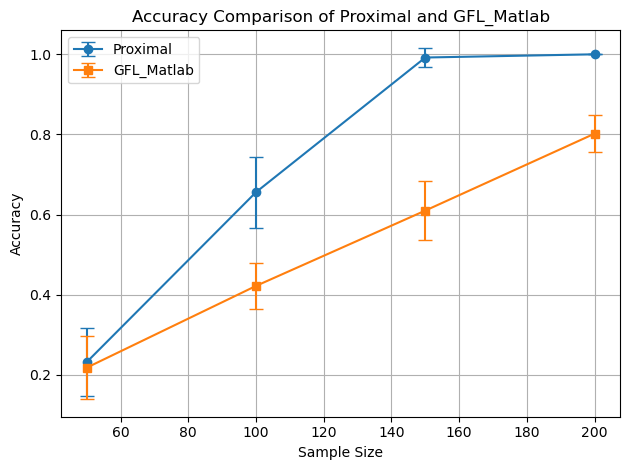

In [14]:
acc_1 = []
acc_2 = []
std_1 = []
std_2 = []

# Extract means and standard deviations for Proximal and GFL_Matlab
for i in range(len(accuracy)):
    mean_1 = np.mean(accuracy[i]['Proximal'])
    stddev_1 = np.std(accuracy[i]['Proximal'])
    acc_1.append(mean_1)
    std_1.append(stddev_1)

    mean_2 = np.mean(accuracy[i]['GFL_Matlab'])
    stddev_2 = np.std(accuracy[i]['GFL_Matlab'])
    acc_2.append(mean_2)
    std_2.append(stddev_2)

# Plot with error bars
plt.errorbar(sample_sizes, acc_1, yerr=std_1, label='Proximal', fmt="-o", capsize=5)
plt.errorbar(sample_sizes, acc_2, yerr=std_2, label='GFL_Matlab', fmt="-s", capsize=5)

# Add labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Proximal and GFL_Matlab')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [33]:
sample_sizes = np.arange(50, 250, 50)
accuracy = []
for n in sample_sizes:
    random_ensemble = RandomEnsemble(n=n, d=1000, k=50, h_total=100, h_selected=5, h_rest=95, gamma=0.05, p=0.95, q=0.01, num_replications=10)
    accuracy.append(random_ensemble.main())

Synthetic dataset 1: Running Lasso_Sklearn model
Lasso coefficients: [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0. -0.
 -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0. -0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.
 -0.  0.  0. -0. -0. -0.  0. -0.  0. -0. -0.  0. -0. -0.  0. -0. -0. -0.
 -0. -0.  0. -0.  0. -0. -0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0.
  0.  0. -0. -0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0. -0.  0.
  0.  0. -0. -0. -0. -0.  0. -0.  0. -0.  0. -0. -0.  0. -0.  0.  0. -0.
  0. -0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0. -0.  0. -0. -0.  0.  0.
  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0. -0.
 -0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0. -0.  0. -0. -0. -0.
 -0.  0. -0.  0. -0. -0. -0.  0. -0.  0.  0.  0.  0. -0. -0. -0. -0. -0.
 -0. -0.  0. -0. -0. -0. -0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0.  0.
  0.  0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0. -0. -0

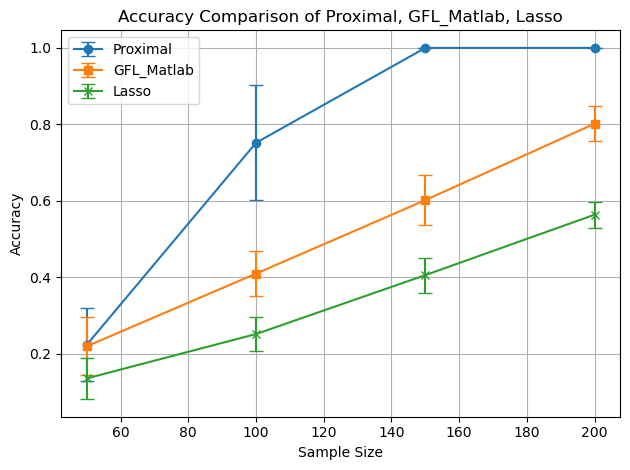

In [21]:
acc_1 = []
acc_2 = []
std_1 = []
std_2 = []
acc_3 = []  
std_3 = []

# Extract means and standard deviations for Proximal and GFL_Matlab
for i in range(len(accuracy)):
    mean_1 = np.mean(accuracy[i]['Proximal'])
    stddev_1 = np.std(accuracy[i]['Proximal'])
    acc_1.append(mean_1)
    std_1.append(stddev_1)

    mean_2 = np.mean(accuracy[i]['GFL_Matlab'])
    stddev_2 = np.std(accuracy[i]['GFL_Matlab'])
    acc_2.append(mean_2)
    std_2.append(stddev_2)

    mean_3 = np.mean(accuracy[i]['Lasso'])
    stddev_3 = np.std(accuracy[i]['Lasso'])
    acc_3.append(mean_3)
    std_3.append(stddev_3)

# Plot with error bars
plt.errorbar(sample_sizes, acc_1, yerr=std_1, label='Proximal', fmt="-o", capsize=5)
plt.errorbar(sample_sizes, acc_2, yerr=std_2, label='GFL_Matlab', fmt="-s", capsize=5)
plt.errorbar(sample_sizes, acc_3, yerr=std_3, label='Lasso', fmt="-x", capsize=5)

# Add labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Proximal, GFL_Matlab, Lasso')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [25]:
sample_sizes = np.arange(50, 250, 50)
accuracy = []
for n in sample_sizes:
    random_ensemble = RandomEnsemble(n=n, d=1000, k=50, h_total=100, h_selected=5, h_rest=95, gamma=0.05, p=0.5, q=0.05, num_replications=10)
    accuracy.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.14400000000000002
rho: 7.0710678118654755, mu: 0.1, acc: 0.148
rho: 7.0710678118654755, mu: 1.0, acc: 0.152
rho: 48.08326112068523, mu: 0.01, acc: 0.14400000000000002
rho: 48.08326112068523, mu: 0.1, acc: 0.148
rho: 48.08326112068523, mu: 1.0, acc: 0.152
Best rho: 7.0710678118654755, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
88 90
88 90
88 90
88 90
88 90
88 90
88 90
88 90
88 90
88 90
57 59
39 41
32 34
31 33
24 26
21 23
18 20
20 22
20 22
20 22
18 20
19 21
19 21
19 21
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
170 172
170 172
170 172
170 172
170 172
170 172
170 172
170 172
170 172
170 172
170 172
125 127
96 98
75 77
68 70
61 63
52 54
51 53
42 44
36 38
34 36
31 33
29 31
28 30
26 28
25 27
24 26
27 29
24 26
22 24
22 24
22 24
22 24
Synthetic dataset 3: Running GFL

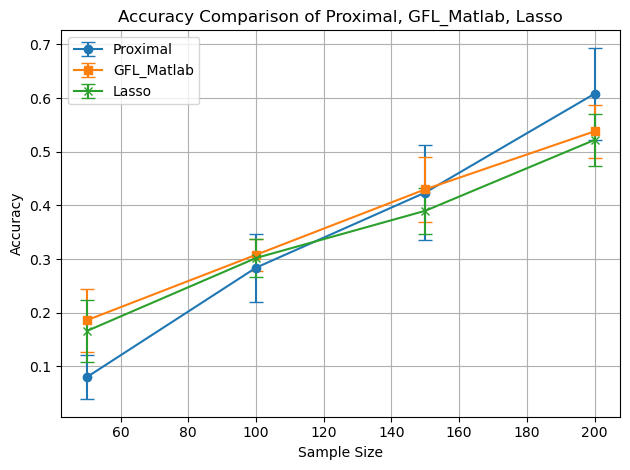

In [26]:
acc_1 = []
acc_2 = []
std_1 = []
std_2 = []
acc_3 = []  
std_3 = []

# Extract means and standard deviations for Proximal and GFL_Matlab
for i in range(len(accuracy)):
    mean_1 = np.mean(accuracy[i]['Proximal'])
    stddev_1 = np.std(accuracy[i]['Proximal'])
    acc_1.append(mean_1)
    std_1.append(stddev_1)

    mean_2 = np.mean(accuracy[i]['GFL_Matlab'])
    stddev_2 = np.std(accuracy[i]['GFL_Matlab'])
    acc_2.append(mean_2)
    std_2.append(stddev_2)

    mean_3 = np.mean(accuracy[i]['Lasso'])
    stddev_3 = np.std(accuracy[i]['Lasso'])
    acc_3.append(mean_3)
    std_3.append(stddev_3)

# Plot with error bars
plt.errorbar(sample_sizes, acc_1, yerr=std_1, label='Proximal', fmt="-o", capsize=5)
plt.errorbar(sample_sizes, acc_2, yerr=std_2, label='GFL_Matlab', fmt="-s", capsize=5)
plt.errorbar(sample_sizes, acc_3, yerr=std_3, label='Lasso', fmt="-x", capsize=5)

# Add labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Proximal, GFL_Matlab, Lasso')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

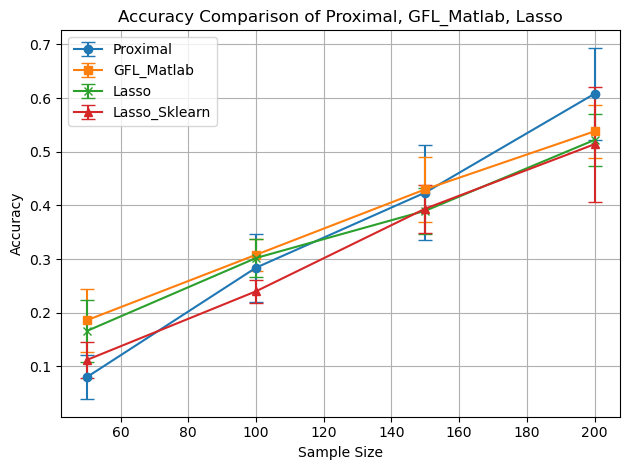

In [43]:
acc_4 = []
std_4 = []
for i in range(len(accuracy)):
    mean_4 = np.mean(accuracy[i]['Lasso_Sklearn']) 
    stddev_4 = np.std(accuracy[i]['Lasso_Sklearn'])
    acc_4.append(mean_4)
    std_4.append(stddev_4)

# Plot with error bars
plt.errorbar(sample_sizes, acc_1, yerr=std_1, label='Proximal', fmt="-o", capsize=5)
plt.errorbar(sample_sizes, acc_2, yerr=std_2, label='GFL_Matlab', fmt="-s", capsize=5)
plt.errorbar(sample_sizes, acc_3, yerr=std_3, label='Lasso', fmt="-x", capsize=5)
plt.errorbar(sample_sizes, acc_4, yerr=std_4, label='Lasso_Sklearn', fmt="-^", capsize=5)

# Add labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Proximal, GFL_Matlab, Lasso')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [41]:
accuracy

[defaultdict(list,
             {'Lasso_Sklearn': [0.06,
               0.16,
               0.1,
               0.14,
               0.12,
               0.14,
               0.06,
               0.08,
               0.14,
               0.12],
              'Lassp_Sklearn': []}),
 defaultdict(list,
             {'Lasso_Sklearn': [0.26,
               0.2,
               0.24,
               0.24,
               0.24,
               0.24,
               0.22,
               0.22,
               0.28,
               0.26],
              'Lassp_Sklearn': []}),
 defaultdict(list,
             {'Lasso_Sklearn': [0.4,
               0.42,
               0.4,
               0.34,
               0.4,
               0.38,
               0.44,
               0.36,
               0.48,
               0.32],
              'Lassp_Sklearn': []}),
 defaultdict(list,
             {'Lasso_Sklearn': [0.54,
               0.64,
               0.26,
               0.48,
               0.66,
            

In [39]:
sample_sizes = np.arange(50, 250, 50)
accuracy = []
for n in sample_sizes:
    random_ensemble = RandomEnsemble(n=n, d=1000, k=50, h_total=100, h_selected=5, h_rest=95, gamma=0.05, p=0.5, q=0.05, num_replications=10)
    accuracy.append(random_ensemble.main())

Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 4: Running Lasso_Sklearn model
Synthetic dataset 5: Running Lasso_Sklearn model
Synthetic dataset 6: Running Lasso_Sklearn model
Synthetic dataset 7: Running Lasso_Sklearn model
Synthetic dataset 8: Running Lasso_Sklearn model
Synthetic dataset 9: Running Lasso_Sklearn model
Synthetic dataset 10: Running Lasso_Sklearn model
Model: Lasso_Sklearn, Avg. Accuracy: 0.11200000000000002, Std. Accuracy: 0.03370459909270544
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 4: Running Lasso_Sklearn model
Synthetic dataset 5: Running Lasso_Sklearn model
Synthetic dataset 6: Running Lasso_Sklearn model
Synthetic dataset 7: Running Lasso_Sklearn model
Synthetic dataset 8: Running Lasso_Sklearn model
Synthetic dataset 9: Run

In [36]:
sample_sizes = np.arange(50, 250, 50)
accuracy = []
for n in sample_sizes:
    random_ensemble = RandomEnsemble(n=n, d=1000, k=50, h_total=100, h_selected=5, h_rest=95, gamma=0.05, p=0.5, q=0.05, num_replications=1)
    accuracy.append(random_ensemble.main())

Synthetic dataset 1: Running Lasso_Sklearn model
Lasso coefficients: [ 0.         -0.          0.          0.          0.01490029  0.
  0.          0.07222668  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.         -0.12317764  0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.02296479  0.          0.         -0.          0.
  0.          0.          0.          0.          0.         -0.
  0.10786419  0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.05290482 -0.         -0.          0.          0.
  0.          0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.16597886  0.          0.
  0.          0.     

In [45]:
sample_sizes = np.arange(50, 500, 50)
accuracy = []
for n in sample_sizes:
    random_ensemble = RandomEnsemble(n=n, d=1000, k=50, h_total=40, h_selected=2, h_rest=38, gamma=0.05, p=0.5, q=0.1, num_replications=20)
    accuracy.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.14800000000000002
rho: 7.0710678118654755, mu: 0.1, acc: 0.15200000000000002
rho: 7.0710678118654755, mu: 1.0, acc: 0.15599999999999997
rho: 48.08326112068523, mu: 0.01, acc: 0.14400000000000002
rho: 48.08326112068523, mu: 0.1, acc: 0.136
rho: 48.08326112068523, mu: 1.0, acc: 0.13999999999999999
Best rho: 7.0710678118654755, Best mu: 1.0
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
872 874
889 891
905 907
911 913
915 917
916 918
919 921
919 921
919 921
920 922
920 922
920 922
937 939
936 938
951 953
948 950
928 930
933 935
920 922
886 888
823 825
779 781
737 739
708 710
671 673
636 638
614 616
581 583
552 554
513 515
479 481
454 456
407 409
383 385
349 351
338 340
320 322
309 311
287 289
270 272
255 257
246 248
237 239
228 230
218 220
212 214
204 206
203 205
197 199
191 193
184 186
185 187
180 182
170 172
167 169
167 169
163 165
153 155
149 151
149 151
144 146

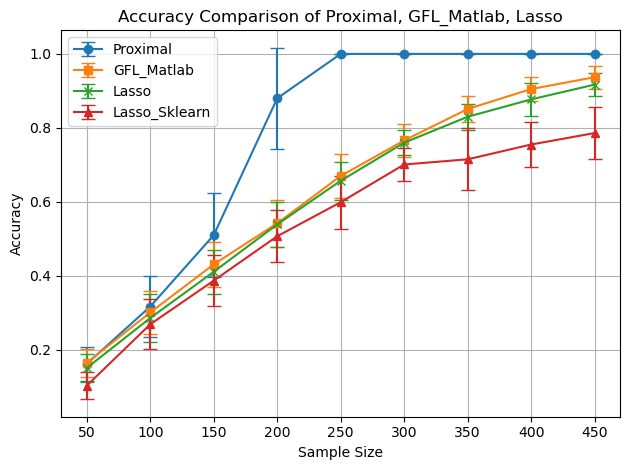

In [48]:
acc_1 = []
acc_2 = []
std_1 = []
std_2 = []
acc_3 = []
std_3 = []
acc_4 = []
std_4 = []


# Extract means and standard deviations for Proximal and GFL_Matlab
for i in range(len(accuracy)):
    mean_1 = np.mean(accuracy[i]['Proximal'])
    stddev_1 = np.std(accuracy[i]['Proximal'])
    acc_1.append(mean_1)
    std_1.append(stddev_1)

    mean_2 = np.mean(accuracy[i]['GFL_Matlab'])
    stddev_2 = np.std(accuracy[i]['GFL_Matlab'])
    acc_2.append(mean_2)
    std_2.append(stddev_2)

    mean_3 = np.mean(accuracy[i]['Lasso'])
    stddev_3 = np.std(accuracy[i]['Lasso'])
    acc_3.append(mean_3)
    std_3.append(stddev_3)

    mean_4 = np.mean(accuracy[i]['Lasso_Sklearn'])
    stddev_4 = np.std(accuracy[i]['Lasso_Sklearn'])
    acc_4.append(mean_4)
    std_4.append(stddev_4)



# Plot with error bars
plt.errorbar(sample_sizes, acc_1, yerr=std_1, label='Proximal', fmt="-o", capsize=5)
plt.errorbar(sample_sizes, acc_2, yerr=std_2, label='GFL_Matlab', fmt="-s", capsize=5)
plt.errorbar(sample_sizes, acc_3, yerr=std_3, label='Lasso', fmt="-x", capsize=5)
plt.errorbar(sample_sizes, acc_4, yerr=std_4, label='Lasso_Sklearn', fmt="-^", capsize=5)

# Add labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Proximal, GFL_Matlab, Lasso')

plt.legend()

plt.grid(True)

plt.tight_layout()

# Display the plot
plt.show()

try mu=1? will this make a difference?
calculate the theoretical n to get exact answer
time?

In [49]:
sample_sizes = np.arange(50, 500, 50)
accuracy_2 = []
for n in sample_sizes:
    random_ensemble = RandomEnsemble(n=n, d=1000, k=50, h_total=40, h_selected=2, h_rest=38, gamma=0.05, p=0.95, q=0.4, num_replications=50)
    accuracy_2.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.092
rho: 7.0710678118654755, mu: 0.1, acc: 0.08800000000000001
rho: 7.0710678118654755, mu: 1.0, acc: 0.08800000000000001
rho: 48.08326112068523, mu: 0.01, acc: 0.084
rho: 48.08326112068523, mu: 0.1, acc: 0.084
rho: 48.08326112068523, mu: 1.0, acc: 0.084
Best rho: 7.0710678118654755, Best mu: 0.01
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
1 3
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 4: Running GFL_Matlab model
Synthetic dataset 4: Running Lasso model
Synthetic dataset 4:

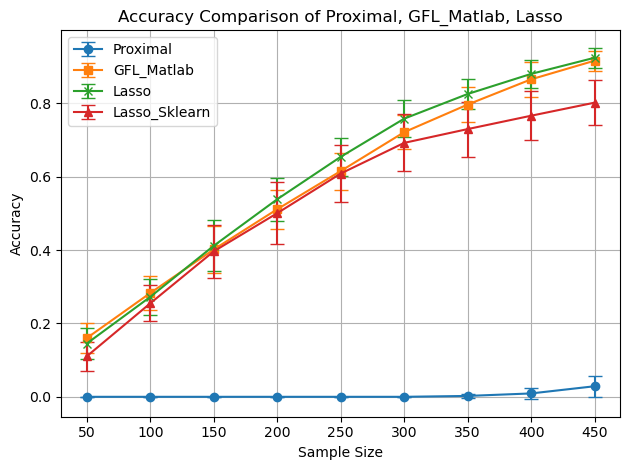

In [50]:
acc_1 = []
acc_2 = []
std_1 = []
std_2 = []
acc_3 = []
std_3 = []
acc_4 = []
std_4 = []


# Extract means and standard deviations for Proximal and GFL_Matlab

for i in range(len(accuracy_2)):
    mean_1 = np.mean(accuracy_2[i]['Proximal'])
    stddev_1 = np.std(accuracy_2[i]['Proximal'])
    acc_1.append(mean_1)
    std_1.append(stddev_1)

    mean_2 = np.mean(accuracy_2[i]['GFL_Matlab'])
    stddev_2 = np.std(accuracy_2[i]['GFL_Matlab'])
    acc_2.append(mean_2)
    std_2.append(stddev_2)

    mean_3 = np.mean(accuracy_2[i]['Lasso'])
    stddev_3 = np.std(accuracy_2[i]['Lasso'])
    acc_3.append(mean_3)
    std_3.append(stddev_3)

    mean_4 = np.mean(accuracy_2[i]['Lasso_Sklearn'])
    stddev_4 = np.std(accuracy_2[i]['Lasso_Sklearn'])
    acc_4.append(mean_4)
    std_4.append(stddev_4)



# Plot with error bars
plt.errorbar(sample_sizes, acc_1, yerr=std_1, label='Proximal', fmt="-o", capsize=5)
plt.errorbar(sample_sizes, acc_2, yerr=std_2, label='GFL_Matlab', fmt="-s", capsize=5)
plt.errorbar(sample_sizes, acc_3, yerr=std_3, label='Lasso', fmt="-x", capsize=5)
plt.errorbar(sample_sizes, acc_4, yerr=std_4, label='Lasso_Sklearn', fmt="-^", capsize=5)

# Add labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Proximal, GFL_Matlab, Lasso')

plt.legend()

plt.grid(True)

plt.tight_layout()

# Display the plot
plt.show()

In [51]:
sample_sizes = np.arange(50, 500, 50)
accuracy_3 = []
for n in sample_sizes:
    random_ensemble = RandomEnsemble(n=n, d=1000, k=50, h_total=40, h_selected=2, h_rest=38, gamma=0.05, p=0.95, q=0.2, num_replications=10)
    accuracy_3.append(random_ensemble.main()) 

Synthetic dataset 1: Running GFL_Matlab model
rho: 7.0710678118654755, mu: 0.01, acc: 0.132
rho: 7.0710678118654755, mu: 0.1, acc: 0.14
rho: 7.0710678118654755, mu: 1.0, acc: 0.14
rho: 48.08326112068523, mu: 0.01, acc: 0.132
rho: 48.08326112068523, mu: 0.1, acc: 0.14
rho: 48.08326112068523, mu: 1.0, acc: 0.14
Best rho: 7.0710678118654755, Best mu: 0.1
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
1 3
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 4: Running GFL_Matlab model
Synthetic dataset 4: Running Lasso model
Synthetic dataset 4: Running Proximal model
1 3
Synth

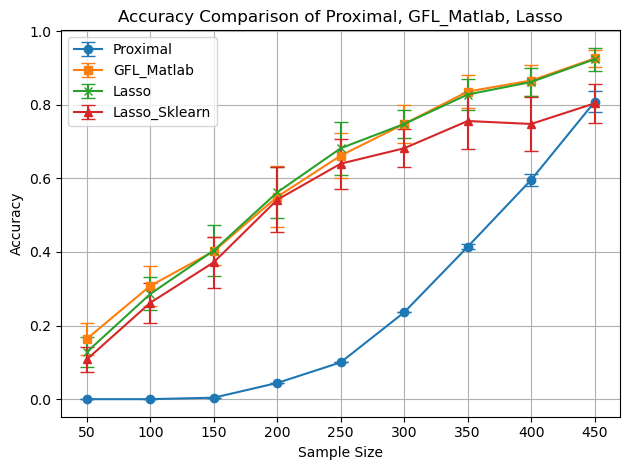

In [52]:
acc_1 = []
acc_2 = []
std_1 = []
std_2 = []
acc_3 = []
std_3 = []
acc_4 = []
std_4 = []


# Extract means and standard deviations for Proximal and GFL_Matlab

for i in range(len(accuracy_3)):
    mean_1 = np.mean(accuracy_3[i]['Proximal'])
    stddev_1 = np.std(accuracy_2[i]['Proximal'])
    acc_1.append(mean_1)
    std_1.append(stddev_1)

    mean_2 = np.mean(accuracy_3[i]['GFL_Matlab'])
    stddev_2 = np.std(accuracy_3[i]['GFL_Matlab'])
    acc_2.append(mean_2)
    std_2.append(stddev_2)

    mean_3 = np.mean(accuracy_3[i]['Lasso'])
    stddev_3 = np.std(accuracy_3[i]['Lasso'])
    acc_3.append(mean_3)
    std_3.append(stddev_3)

    mean_4 = np.mean(accuracy_3[i]['Lasso_Sklearn'])
    stddev_4 = np.std(accuracy_3[i]['Lasso_Sklearn'])
    acc_4.append(mean_4)
    std_4.append(stddev_4)



# Plot with error bars
plt.errorbar(sample_sizes, acc_1, yerr=std_1, label='Proximal', fmt="-o", capsize=5)
plt.errorbar(sample_sizes, acc_2, yerr=std_2, label='GFL_Matlab', fmt="-s", capsize=5)
plt.errorbar(sample_sizes, acc_3, yerr=std_3, label='Lasso', fmt="-x", capsize=5)
plt.errorbar(sample_sizes, acc_4, yerr=std_4, label='Lasso_Sklearn', fmt="-^", capsize=5)

# Add labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Proximal, GFL_Matlab, Lasso')

plt.legend()

plt.grid(True)

plt.tight_layout()

# Display the plot
plt.show()